# Classification of football players

In [38]:
#Import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

In [27]:
#Load dataset
players_df = pd.read_csv('football_players.csv', encoding_errors='ignore')

## Most common overall score

In [20]:
common_score = players_df['Overall'].value_counts()
print(common_score)

Overall
66.0    1105
67.0    1072
64.0    1056
68.0    1033
65.0    1015
63.0     917
69.0     908
70.0     905
71.0     841
62.0     814
72.0     715
60.0     689
61.0     681
73.0     676
74.0     579
59.0     501
58.0     456
75.0     454
57.0     377
76.0     370
56.0     314
77.0     293
55.0     288
54.0     255
78.0     230
53.0     227
79.0     175
52.0     174
51.0     131
80.0     127
50.0     115
82.0     101
81.0      93
83.0      71
49.0      49
84.0      35
85.0      23
86.0      23
48.0      23
47.0      16
88.0      14
87.0      13
89.0       8
46.0       8
90.0       5
92.0       3
91.0       1
94.0       1
93.0       1
Name: count, dtype: int64


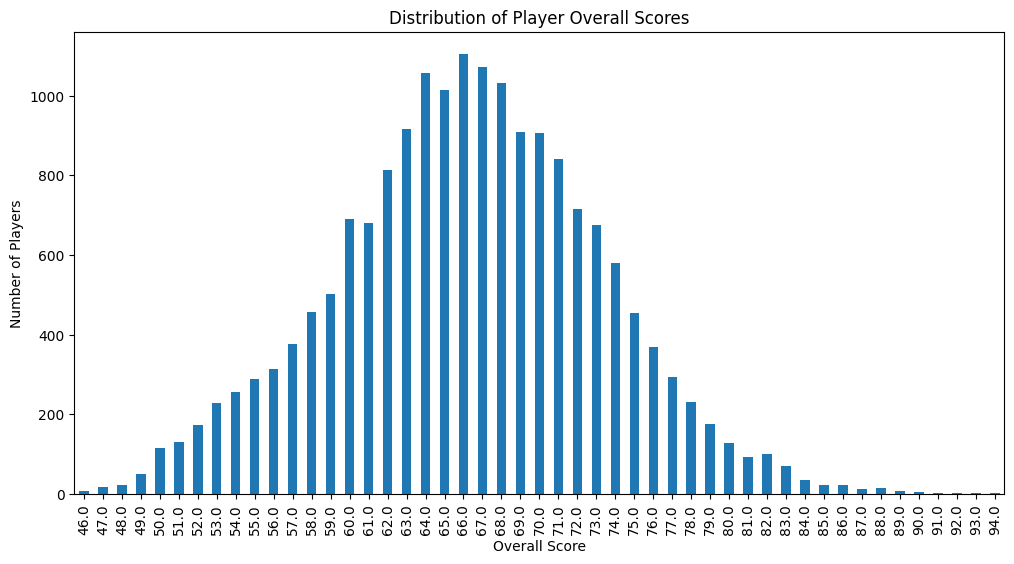

## Identify top 5 most important features

In [25]:
#Filter the data for centre backs
cb = players_df[players_df['Preferred Positions'].str.contains('CB', na=False)].copy()
cb.head()

,Name,Age,Nationality,Overall,Acceleration,Aggression,Agility,Balance,Ball control,Composure,...,Shot power,Sliding tackle,Sprint speed,Stamina,Standing tackle,Strength,Vision,Volleys,Preferred Positions,Preferred Positions Type
10,Sergio Ramos,31,Spain,90.0,75.0,84.0,79.0,60.0,84.0,80.0,...,79.0,91.0,77.0,84.0,89.0,81.0,63.0,66.0,CB,Back
17,G. Chiellini,32,Italy,89.0,68.0,92.0,59.0,64.0,57.0,82.0,...,78.0,90.0,78.0,68.0,92.0,91.0,50.0,45.0,CB,Back
24,L. Bonucci,30,Italy,88.0,62.0,82.0,60.0,52.0,75.0,84.0,...,74.0,88.0,72.0,73.0,88.0,85.0,74.0,58.0,CB,Back
25,J. Boateng,28,Germany,88.0,72.0,82.0,58.0,53.0,71.0,86.0,...,79.0,90.0,78.0,74.0,91.0,91.0,76.0,53.0,CB,Back
26,D. Godn,31,Uruguay,88.0,62.0,86.0,63.0,58.0,76.0,82.0,...,67.0,89.0,67.0,67.0,86.0,80.0,52.0,47.0,CB,Back


## Create the target classes

**World class overall score of 80 or more**

**Good overall score of 70 - 79**

**Mediocre overall score of 69 and below**

In [29]:
conditions = [
    (cb['Overall'] >= 80),
    (cb['Overall'] >= 70) & (cb['Overall'] < 80),
    (cb['Overall'] < 70)
]

choices = ['World Class', 'Good', 'Mediocre']
cb['Class'] = pd.cut(cb['Overall'], 
                           bins=[0, 70, 80, 100],
                           labels=['Mediocre', 'Good', 'World Class'])

## Get features and target

In [30]:
# Select numerical features (exclude non-numerical and target-related columns)
exclude_cols = ['Name', 'Nationality', 'Overall', 'Preferred Positions', 'Preferred Positions Type', 'Class']
numerical_features = [col for col in cb.columns 
                     if col not in exclude_cols and 
                     pd.api.types.is_numeric_dtype(cb[col])]

X = cb[numerical_features]
y = cb['Class']

## Train a Random Forest Classifier

In [36]:
rf = RandomForestClassifier(n_estimators=500, 
                          random_state=1971) 
rf.fit(X, y)

RandomForestClassifier(n_estimators=500, random_state=1971)

## Get the top 5

In [40]:
# Create feature importance DataFrame
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

# Display top 5 features
top_5_features = feature_importance.head()
print(top_5_features[['Feature', 'Importance']].to_string(index=False))

        Feature  Importance
Standing tackle    0.171819
        Marking    0.135030
  Interceptions    0.116153
 Sliding tackle    0.108966
      Reactions    0.072721


## Prepare the data using the cb dataset

In [42]:
X = cb[numerical_features]
y = cb['Class']

#Split into training and testing 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state=911)

## Compare KNN Models (k=1 to 5)

In [43]:
results = {}

for k in range(1, 6):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    
    # Calculate F1 scores per class (World Class/Good only)
    f1 = f1_score(y_test, y_pred, average=None, labels=['World Class', 'Good'])
    results[k] = {
        'World Class F1': f1[0],
        'Good F1': f1[1]
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)

   World Class F1   Good F1
1        0.523810  0.760656
2        0.424242  0.787356
3        0.540541  0.810084
4        0.470588  0.804382
5        0.600000  0.802768


## Identify the best k for each class

In [44]:
best_k_world_class = results_df['World Class F1'].idxmax()
best_k_good = results_df['Good F1'].idxmax()

print(f"Best k for World Class: {best_k_world_class} (F1 = {results_df.loc[best_k_world_class, 'World Class F1']:.3f})")
print(f"Best k for Good: {best_k_good} (F1 = {results_df.loc[best_k_good, 'Good F1']:.3f})")

Best k for World Class: 5 (F1 = 0.600)
Best k for Good: 3 (F1 = 0.810)
